# Parameter Estimation of RIG Roll Experiments

## Setup and descriptions

* Without ACM model
* Turn on wind tunnel
* Only 1DoF for RIG roll movement
* Use **small-amplitude** aileron command of CMP as inputs (in degrees)
$$U = \delta_{a,cmp}(t)$$
* Consider RIG roll angle and its derivative as States (in radians)
$$X = \begin{pmatrix} \phi_{rig} \\ \dot{\phi}_{rig} \end{pmatrix}$$
* Observe RIG roll angle and its derivative as Outputs (in degrees)
$$Z = \begin{pmatrix} \phi_{rig} \\ \dot{\phi}_{rig} \end{pmatrix}$$
* Use output error method based on most-likehood(ML) to estimate
$$ \theta = \begin{pmatrix} C_{l,\delta_a,cmp} \\ C_{lp,cmp}  \end{pmatrix} $$

## Startup computation engines

In [2]:
%run matt_startup
%run -i matt_utils

button_qtconsole()

#import other needed modules in all used engines
#with dview.sync_imports():
#   import os

importing numpy on engine(s)
importing scipy on engine(s)
importing matplotlib on engine(s)
importing scipy.integrate on engine(s)
importing scipy.interpolate on engine(s)
importing math on engine(s)
importing time on engine(s)
importing itertools on engine(s)
importing random on engine(s)


## Data preparation

### Load raw data

In [3]:
filename = 'FIWT_Exp051_20150612163239.dat.npz'

def loadData():
    # Read and parse raw data
    global exp_data
    exp_data = np.load(filename)

    # Select colums
    global T_cmp, da1_cmp, da2_cmp, da3_cmp , da4_cmp
    T_cmp = exp_data['data33'][:,0]
    da1_cmp = exp_data['data33'][:,3]
    da2_cmp = exp_data['data33'][:,5]
    da3_cmp = exp_data['data33'][:,7]
    da4_cmp = exp_data['data33'][:,9]

    global T_rig, phi_rig
    T_rig = exp_data['data44'][:,0]
    phi_rig = exp_data['data44'][:,2]

loadData()

### Check time sequence and inputs/outputs

Click 'Check data' button to show the raw data. 

Click on curves to select time point and push into queue; click 'T/s' text to pop up last point in the queue; and click 'Output' text to print time sequence table.

In [4]:
def checkInputOutputData():

    #check inputs/outputs
    fig, ax = plt.subplots(2,1,True)
    ax[0].plot(T_cmp,da1_cmp,'r', T_cmp,da2_cmp,'g',
               T_cmp,da3_cmp,'b', T_cmp,da4_cmp,'m',
               picker=1)
    ax[1].plot(T_rig,phi_rig, 'b', picker=2)
    ax[0].set_ylabel('$\delta \/ / \/ ^o$')
    ax[1].set_ylabel('$\phi \/ / \/ ^o/s$')
    ax[1].set_xlabel('$T \/ / \/ s$', picker=True)
    ax[0].set_title('Output', picker=True)
    

    fig.canvas.mpl_connect('pick_event', onPickTime)
    fig.show()
    display(fig)

button_CheckData()

### Input data set information and do processing

For each section,
* Select time range and shift it to start from zero;
* Resample Time, Inputs, Outputs in unique $\delta_T$;
* Smooth Input/Observe data if flag bit0 is set;
* Take derivatives of observe data if flag bit1 is set.

In [8]:

# Decide DT,U,Z and their processing method
process_set1 = {
            # Pick up focused time ranges
            'time_marks' : [
                [10.244684487,71.0176928039,"ramp cmp1 u1"],
                [75.590251771,136.676120954,"ramp cmp1 d1"],
                [138.085246353,198.267991292,"ramp cmp2 u1"],
                [202.947148504,263.947709116,"ramp cmp2 d1"],
                [265.320787191,326.086083756,"ramp cmp2 d2"],
                [328.651258032,387.065040394,"ramp cmp3 u1"],
                [391.213644461,451.562391555,"ramp cmp3 d1"],
                [454.129343981,513.129351723,"ramp cmp4 u1"],
                [515.902028523,577.039776316,"ramp cmp4 d1"],
                [580.1785085,679.5971965,"ramp cmp1/3 d1"],
                [683.479931261,783.589410569,"ramp cmp1/3 d2"],
                [785.543756555,885.058700497,"ramp cmp1/3 u1"],
                [889.116441348,987.763826608,"ramp cmp2/4 d1"],
                [992.08250855,1089.55268169,"ramp cmp2/4 u1"],
                [1098.5355005,1216.24487648,"ramp cmpall u1"],
                [1220.27886043,1340.49709824,"ramp cmpall u2"],
                [1343.59303659,1464.78924788,"ramp cmpall d1"],
            ],
            'U':[(T_cmp, da1_cmp,0),
                (T_cmp, da2_cmp,0),
                (T_cmp, da3_cmp,0),
                (T_cmp, da4_cmp,0),],
            'U_names' : ['$\delta_{a1,cmp} \, / \, ^o$',
                      '$\delta_{a2,cmp} \, / \, ^o$',
                      '$\delta_{a3,cmp} \, / \, ^o$',
                      '$\delta_{a4,cmp} \, / \, ^o$'],
            'Z':[(T_rig, phi_rig,1),],
            'Z_names' : ['$\phi_{a,rig} \, / \, ^o$'],
            'cutoff_freq': 1, #Hz
            'consts' : {'DT':0.1, 'id':0, 'V':30}
           }

display_data_set(process_set1)
resample(process_set1, append=False);

Idx,Start(s),Spam(s),Description
16,10.24,60.77,ramp cmp1 u1
17,75.59,61.09,ramp cmp1 d1
18,138.09,60.18,ramp cmp2 u1
19,202.95,61.00,ramp cmp2 d1
20,265.32,60.77,ramp cmp2 d2
21,328.65,58.41,ramp cmp3 u1
22,391.21,60.35,ramp cmp3 d1
23,454.13,59.00,ramp cmp4 u1
24,515.90,61.14,ramp cmp4 d1
25,580.18,99.42,ramp cmp1/3 d1


$U$
"$\delta_{a1,cmp} \, / \, ^o$"
"$\delta_{a2,cmp} \, / \, ^o$"
"$\delta_{a3,cmp} \, / \, ^o$"
"$\delta_{a4,cmp} \, / \, ^o$"


$Z$
"$\phi_{a,rig} \, / \, ^o$"


Constant,Value
DT,0.1
id,0
V,30


## Define dynamic model to be estimated

$$\left\{\begin{matrix}\begin{align}
M_{x,rig} &= M_{x,a} + M_{x,f} + M_{x,cg} = 0 \\
M_{x,a} &= \frac{1}{2} \rho V^2S_cb_c  C_{la,cmp}\delta_{a,cmp} \\
M_{x,f} &= -F_c \, sign(\dot{\phi}_{rig}) \\
M_{x,cg} &= -m_T g  l_{zT} \sin \left ( \phi - \phi_0 \right )
\end{align}\end{matrix}\right.$$



In [9]:
%%px --local
#update common const parameters in all engines

angles = range(-40,41,5)
angles[0] -= 1
angles[-1] += 1
del angles[angles.index(0)]
angles_num = len(angles)

#problem size
Nx = 0
Nu = 4
Ny = 1
Npar = 4*angles_num+1

#reference
S_c = 0.1254   #S_c(m2) 
b_c = 0.7      #b_c(m)
g = 9.81       #g(m/s2)

#static measurement
m_T = 7.5588   #m_T(kg)
l_z_T = 0.0424250531303 #l_z_T(m)

#previous estimations
F_c = 0.0532285873599 #F_c(N*m)
Clda_cmp = -0.315904095782 #Clda_cmp(1/rad)
Clphi_cmp = -0.0131776778575 #Clphi_cmp(1/rad)

#for short
_m_T_l_z_T_g = -(m_T*l_z_T)*g


def obs(Z,T,U,params,consts):
    DT = consts['DT']
    ID = consts['id']
    V  = consts['V']

    k1 = np.array(params[0:angles_num])
    k2 = np.array(params[angles_num:angles_num*2])
    k3 = np.array(params[angles_num*2:angles_num*3])
    k4 = np.array(params[angles_num*3:angles_num*4])
    phi0 = params[-1]

    Clda1 = scipy.interpolate.interp1d(angles, Clda_cmp*0.00436332313*k1*angles,assume_sorted=True)
    Clda2 = scipy.interpolate.interp1d(angles, Clda_cmp*0.00436332313*k2*angles,assume_sorted=True)
    Clda3 = scipy.interpolate.interp1d(angles, Clda_cmp*0.00436332313*k3*angles,assume_sorted=True)
    Clda4 = scipy.interpolate.interp1d(angles, Clda_cmp*0.00436332313*k4*angles,assume_sorted=True)
    
    s = T.size
    qbarSb = 0.5*1.225*V*V*S_c*b_c
    moments_a = qbarSb*(Clda1(U[:s,0])+Clda2(U[:s,1])
                       +Clda3(U[:s,2])+Clda4(U[:s,3]))

    phi = phi0+np.arcsin(np.clip(-moments_a/_m_T_l_z_T_g, -1, 1))
    
    moments_f = np.copysign(F_c, phi);
    moments_p = qbarSb*Clphi_cmp*phi;
    
    phi = phi0+np.arcsin(np.clip(-(moments_a+moments_p+moments_f)/_m_T_l_z_T_g, -1, 1))

    return (phi*57.3).reshape((-1,1))



In [11]:
display(HTML('<b>Constant Parameters</b>'))
table = ListTable()
table.append(['Name','Value','unit'])
table.append(['$S_c$',S_c,'$m^2$'])
table.append(['$b_c$',b_c,'$m$'])
table.append(['$g$',g,'$m/s^2$'])
table.append(['$m_T$',m_T,'$kg$'])
table.append(['$l_{zT}$',l_z_T,'$m$'])
table.append(['$F_c$',F_c,'$Nm$'])
table.append(['$C_{l \delta a,cmp}$',Clda_cmp,'$rad^{-1}$'])
table.append(['$C_{l \phi,cmp}$',Clphi_cmp,'$rad^{-1}$'])
display(table)


Name,Value,unit
$S_c$,0.1254,$m^2$
$b_c$,0.7,$m$
$g$,9.81,$m/s^2$
$m_T$,7.5588,$kg$
$l_{zT}$,0.0424250531303,$m$
$F_c$,0.0532285873599,$Nm$
"$C_{l \delta a,cmp}$",-0.315904095782,$rad^{-1}$
"$C_{l \phi,cmp}$",-0.0131776778575,$rad^{-1}$


# Initial guess

* Input default values and ranges for parameters
* Select sections for trainning
* Adjust parameters based on simulation results
* Decide start values of parameters for optimization

In [12]:
#initial guess
param0 = [1]*(4*angles_num)+[0]

param_name = ['k_{}_{}'.format(i/angles_num+1, angles[i%angles_num]) for i in range(4*angles_num)] + ['$phi_0$']
param_unit = ['1']*(4*angles_num) + ['$rad$']

NparID = Npar
opt_idx = range(Npar)
opt_param0 = [param0[i] for i in opt_idx]
par_del = [0.001]*(4*angles_num) + [0.0001]
bounds =  [(0,1.5)]*(4*angles_num) +[(-0.1, 0.1)]
display_default_params()

#select sections for training
section_idx = range(9)
del section_idx[3]
display_data_for_train()

#push parameters to engines
push_opt_param()

Idx,Description,$x_0$,unit,opt,$\delta_{par}$,min,max
0,k_1_-41,1,1,*,0.001,0,1.5
1,k_1_-35,1,1,*,0.001,0,1.5
2,k_1_-30,1,1,*,0.001,0,1.5
3,k_1_-25,1,1,*,0.001,0,1.5
4,k_1_-20,1,1,*,0.001,0,1.5
5,k_1_-15,1,1,*,0.001,0,1.5
6,k_1_-10,1,1,*,0.001,0,1.5
7,k_1_-5,1,1,*,0.001,0,1.5
8,k_1_5,1,1,*,0.001,0,1.5
9,k_1_10,1,1,*,0.001,0,1.5


Idx,Start(s),Spam(s),Description
0,10.24,60.77,ramp cmp1 u1
1,75.59,61.09,ramp cmp1 d1
2,138.09,60.18,ramp cmp2 u1
4,265.32,60.77,ramp cmp2 d2
5,328.65,58.41,ramp cmp3 u1
6,391.21,60.35,ramp cmp3 d1
7,454.13,59.00,ramp cmp4 u1
8,515.90,61.14,ramp cmp4 d1


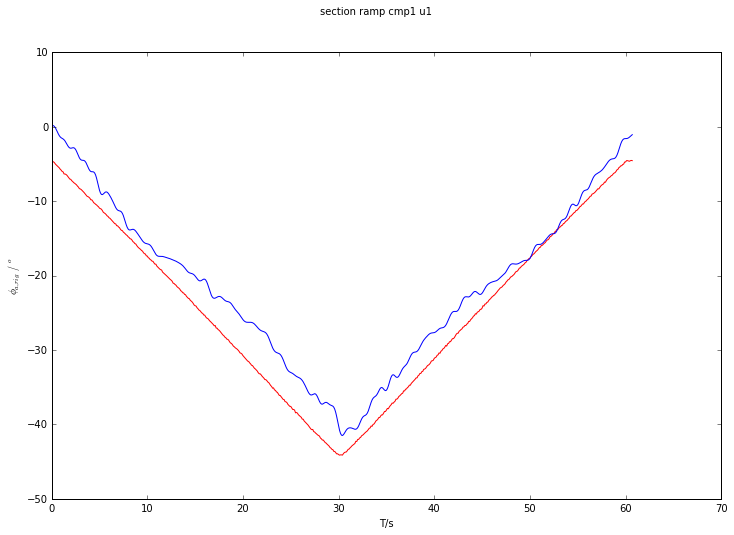

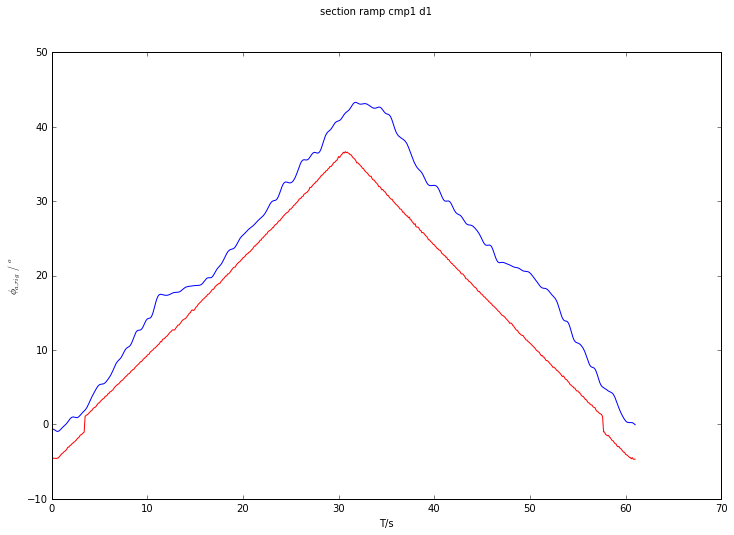

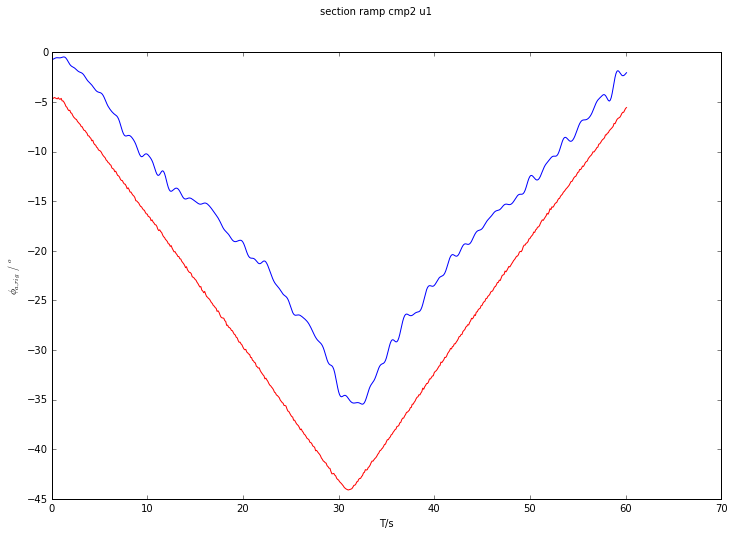

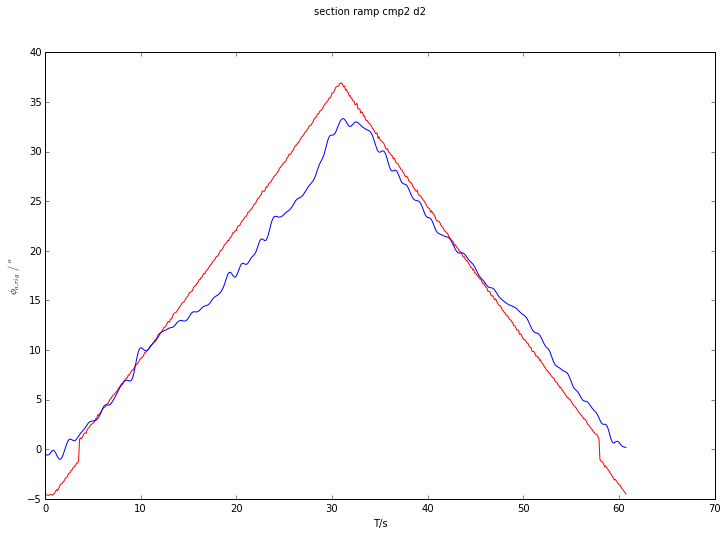

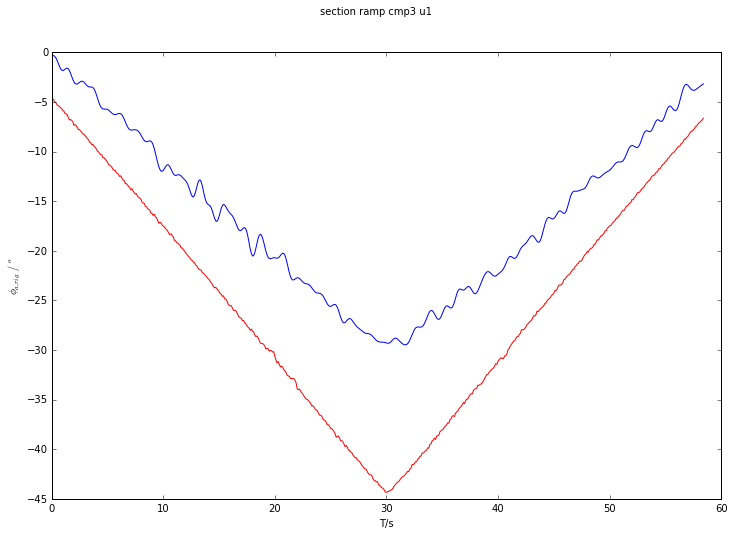

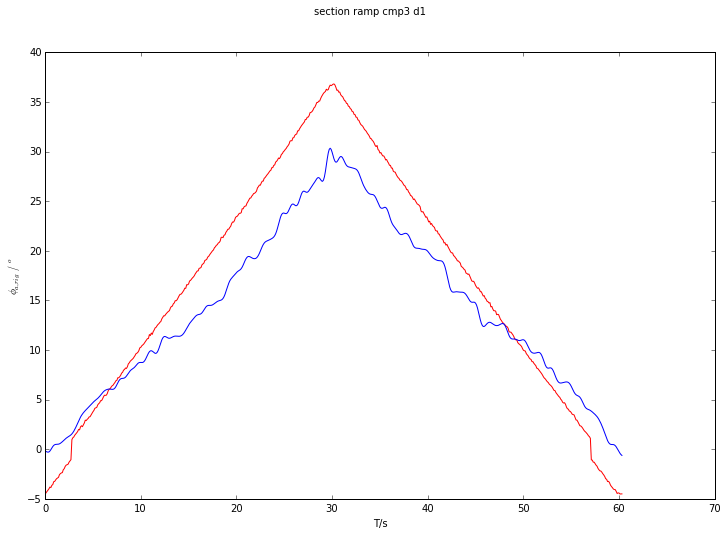

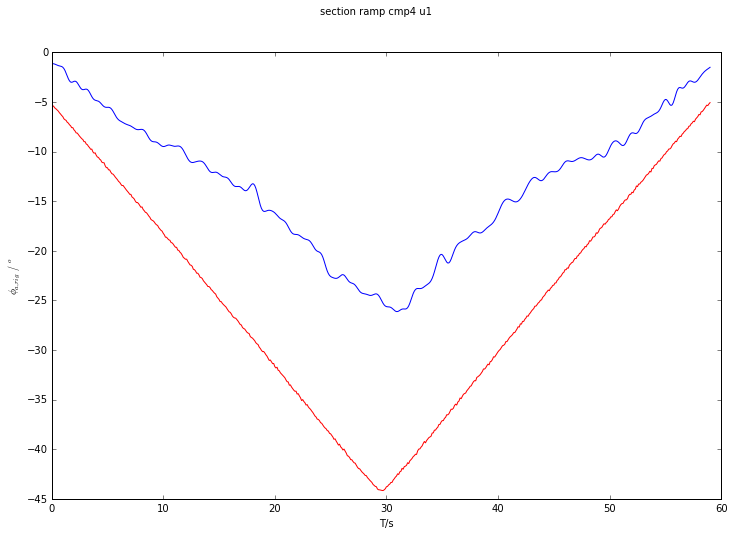

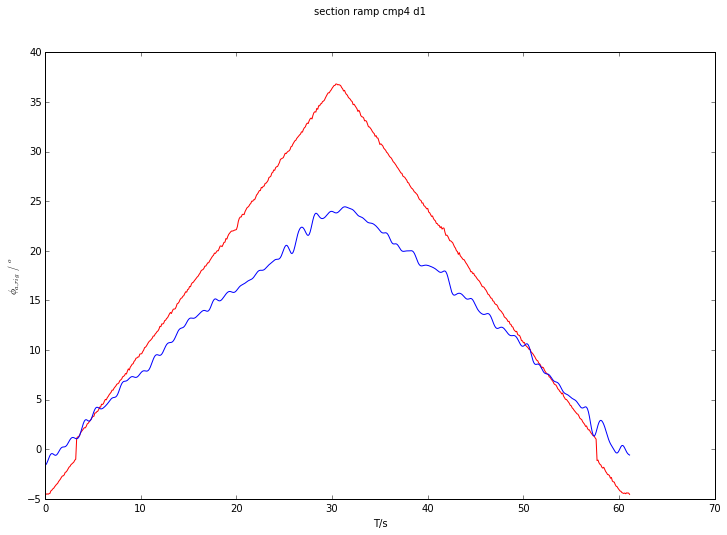

In [13]:
# select 4 section from training data
#idx = random.sample(section_idx, 4)
idx = section_idx[:]

interact_guess();

# Optimize using ML

In [14]:
display_preopt_params()

if False:
    InfoMat = None
    method = 'trust-ncg'
    def hessian(opt_params, index):
        global InfoMat
        return InfoMat
    dview['enable_infomat']=True
    options={'gtol':1}
    opt_bounds = None
else:
    method = 'L-BFGS-B'
    hessian = None
    dview['enable_infomat']=False
    options={'ftol':1e-6,'maxfun':400}
    opt_bounds = bounds

cnt = 0
tmp_rslt = None
T0 = time.time()
print('#cnt,     Time,      |R|')

%time res =  sp.optimize.minimize(fun=costfunc, x0=opt_param0, \
        args=(opt_idx,), method=method, jac=True, hess=hessian, \
        bounds=opt_bounds, options=options)


Idx,Description,$x_0$,unit,opt,$\delta_{par}$,min,max
0,k_1_-41,1.0,1,*,0.001,0,1.5
1,k_1_-35,1.0,1,*,0.001,0,1.5
2,k_1_-30,1.0,1,*,0.001,0,1.5
3,k_1_-25,1.0,1,*,0.001,0,1.5
4,k_1_-20,1.0,1,*,0.001,0,1.5
5,k_1_-15,1.0,1,*,0.001,0,1.5
6,k_1_-10,1.0,1,*,0.001,0,1.5
7,k_1_-5,1.0,1,*,0.001,0,1.5
8,k_1_5,1.0,1,*,0.001,0,1.5
9,k_1_10,1.0,1,*,0.001,0,1.5


#cnt,     Time,      |R|
0001,    0.602,       50.5
0002,    1.042,      681.2
0003,    1.523,       13.6
0004,    2.074,       16.1
0005,    2.643,       44.4
0006,    3.223,       11.3
0007,    3.972,        8.9
0008,    4.842,      405.5
0009,    5.441,       25.6
0010,    6.001,       12.5
0011,    6.550,        9.3
0012,    7.120,        8.8
0013,    7.688,       12.7
0014,    8.200,        9.6
0015,    8.687,        8.9
0016,    9.199,        8.7
0017,    9.674,       11.3
0018,   10.206,        9.2
0019,   10.789,        8.7
0020,   11.288,        8.5
0021,   11.763,        8.4
0022,   12.385,        8.1
0023,   12.862,        7.2
0024,   13.375,        5.9
0025,   13.865,        5.7
0026,   14.335,        5.2
0027,   14.831,        4.6
0028,   15.311,        3.6
0029,   15.835,        3.4
0030,   16.414,        3.0
0031,   16.924,        2.8
0032,   17.401,        2.7
0033,   17.910,        2.5
0034,   18.409,        2.6
0035,   18.901,        2.5
0036,   19.421,        2.4
003

## Show and test results

Idx,Description,$x$
0,k_1_-41,1.05607186044
1,k_1_-35,1.14674232314
2,k_1_-30,1.13577858878
3,k_1_-25,1.12871891243
4,k_1_-20,1.14706612554
5,k_1_-15,1.31098200523
6,k_1_-10,1.3343763375
7,k_1_-5,1.3069849105
8,k_1_5,0.7214486402
9,k_1_10,1.02138245625


Idx,Start(s),Spam(s),Description
0,10.24,60.77,ramp cmp1 u1
1,75.59,61.09,ramp cmp1 d1
2,138.09,60.18,ramp cmp2 u1
3,202.95,61.00,ramp cmp2 d1
4,265.32,60.77,ramp cmp2 d2
5,328.65,58.41,ramp cmp3 u1
6,391.21,60.35,ramp cmp3 d1
7,454.13,59.00,ramp cmp4 u1
8,515.90,61.14,ramp cmp4 d1
9,580.18,99.42,ramp cmp1/3 d1


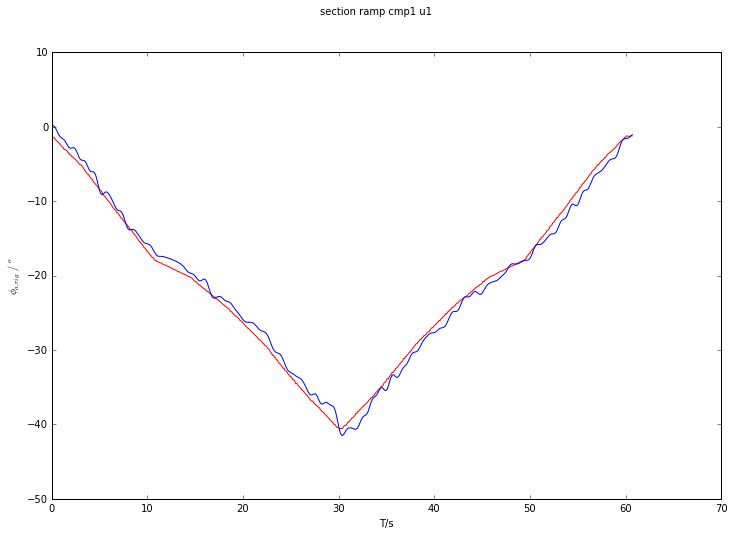

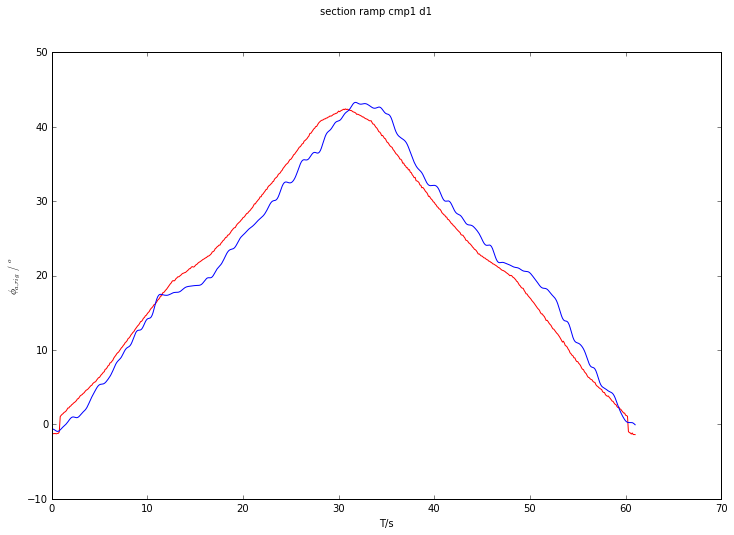

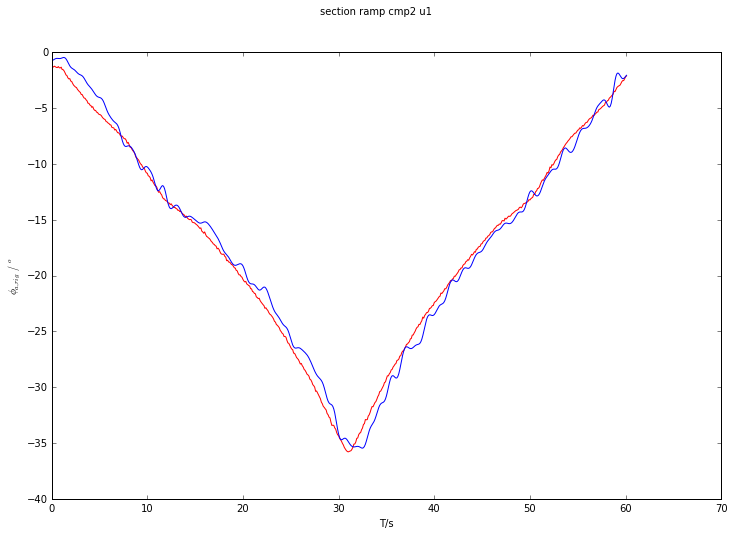

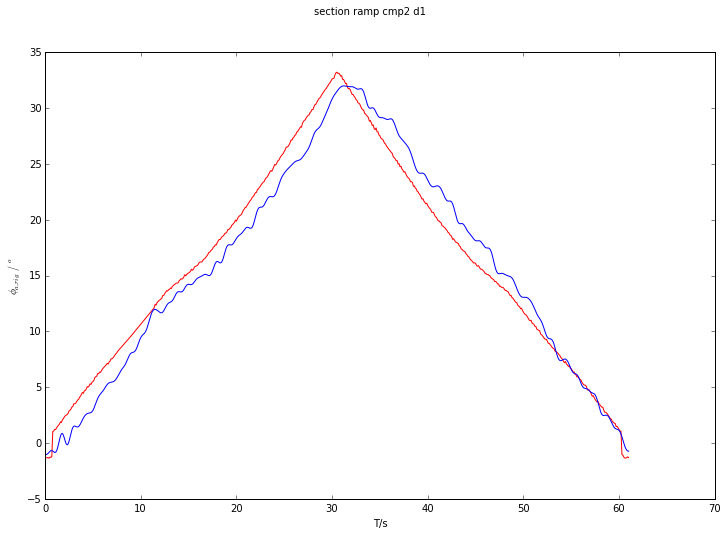

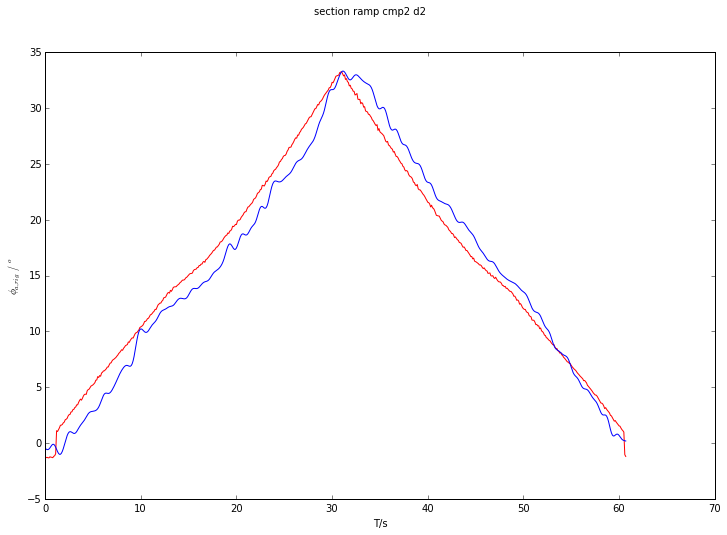

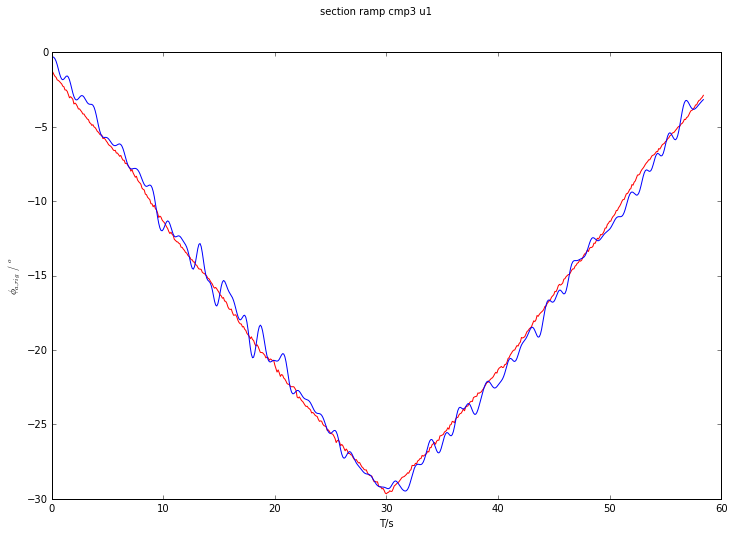

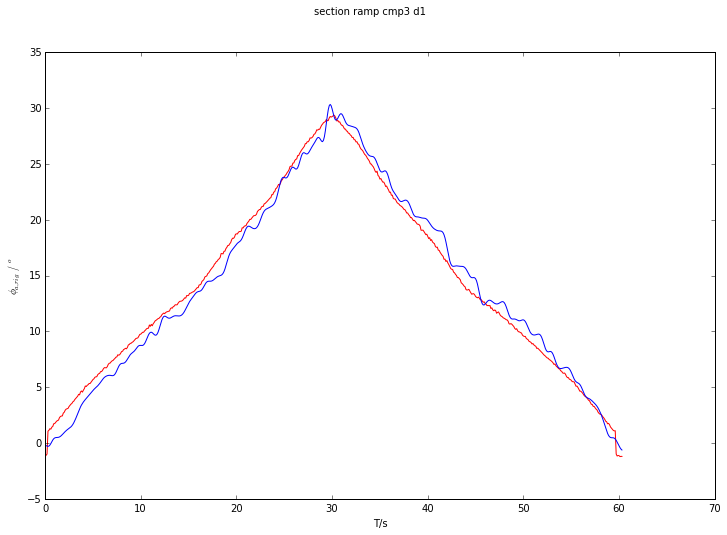

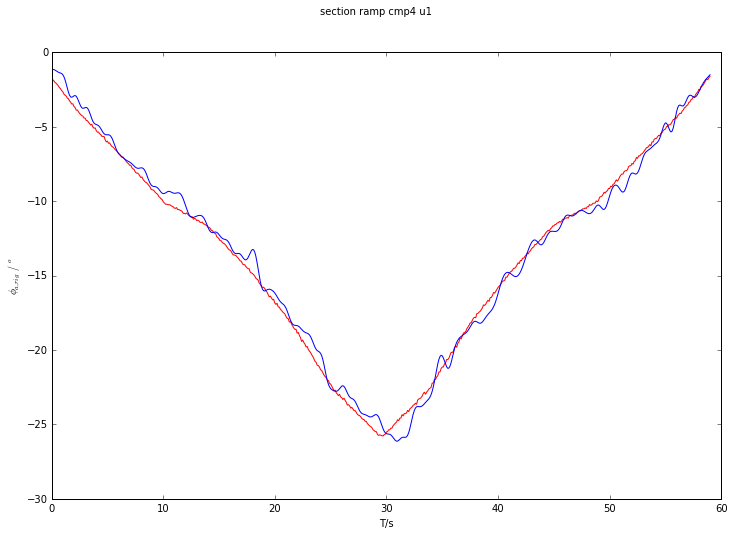

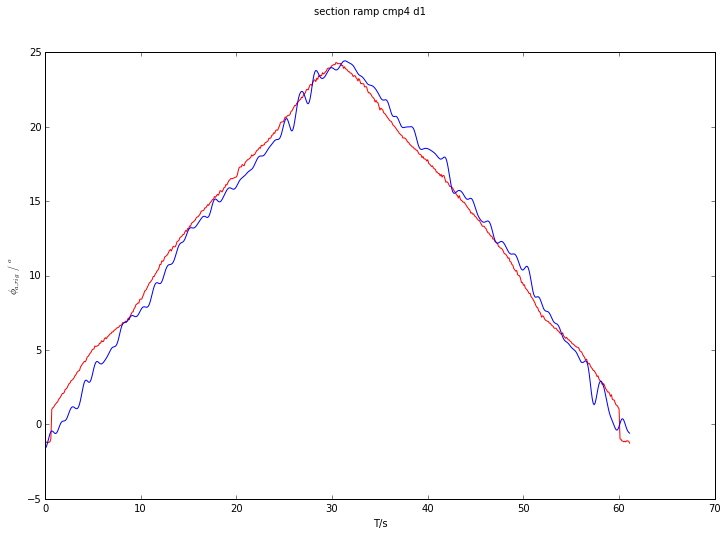

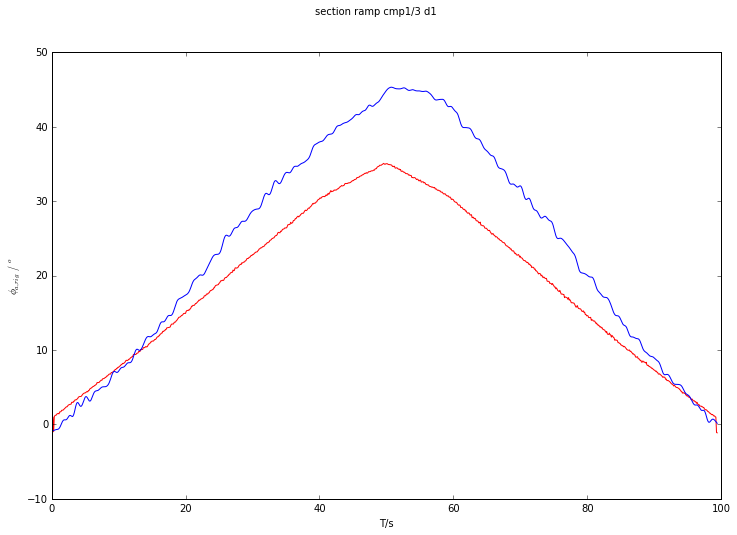

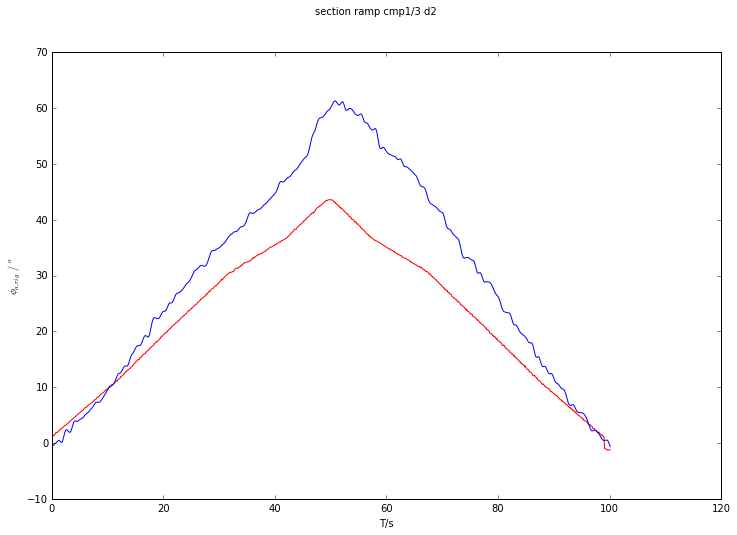

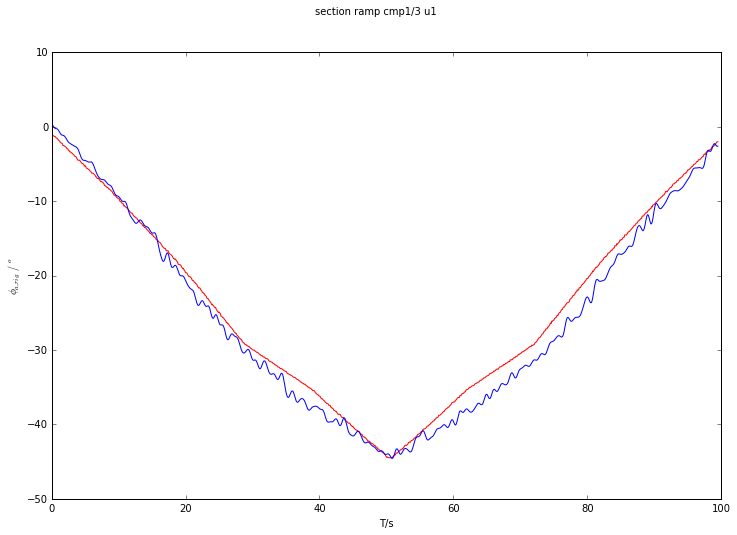

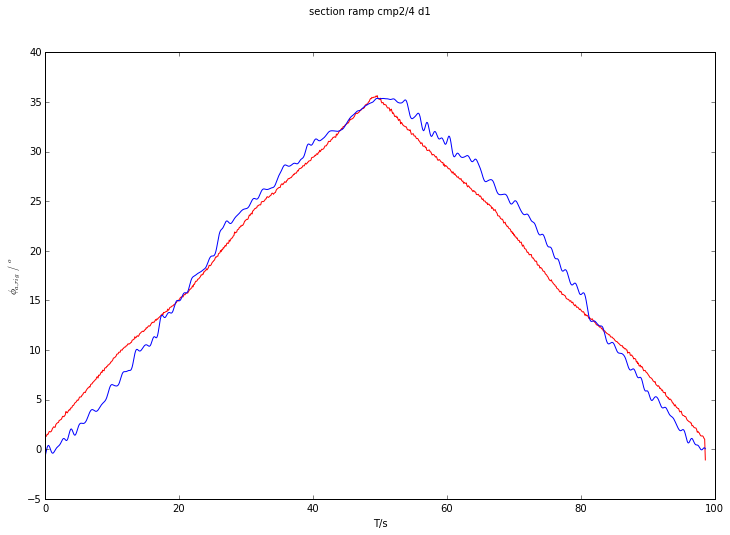

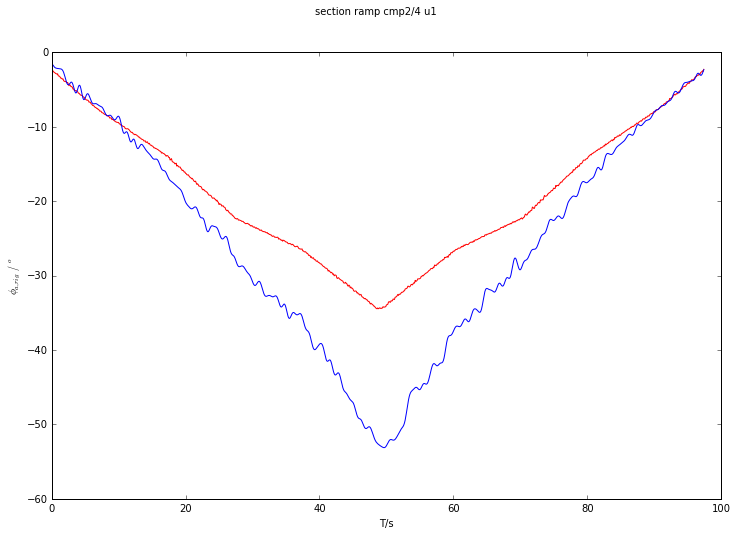

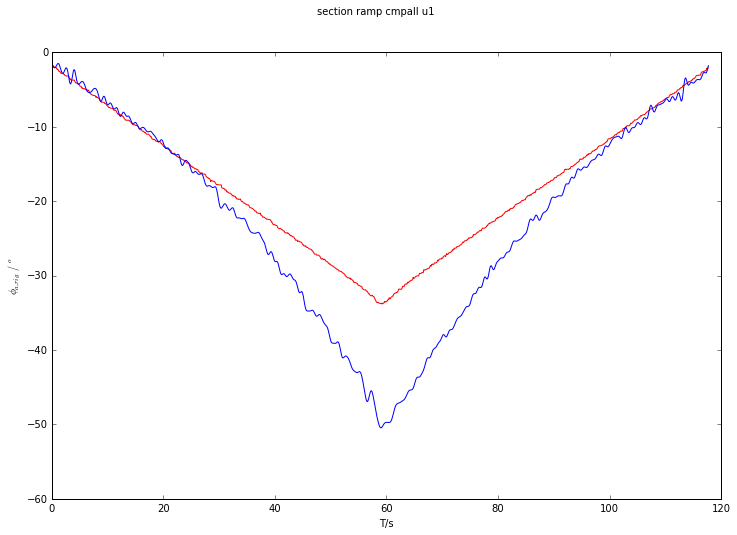

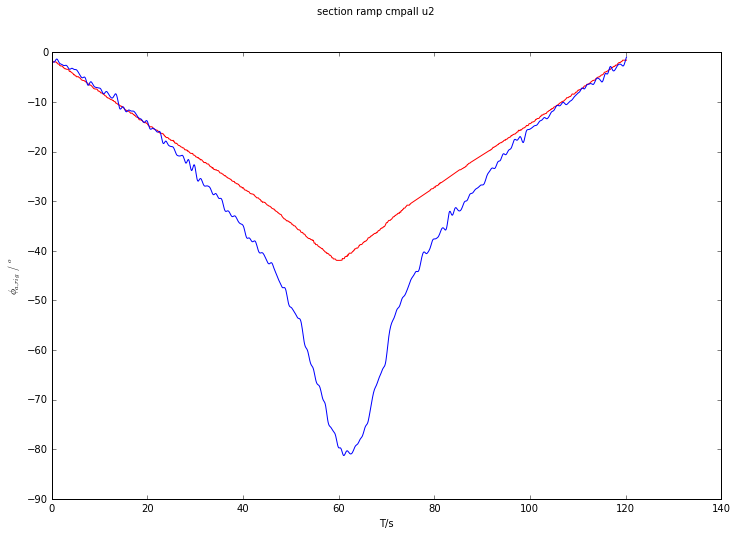

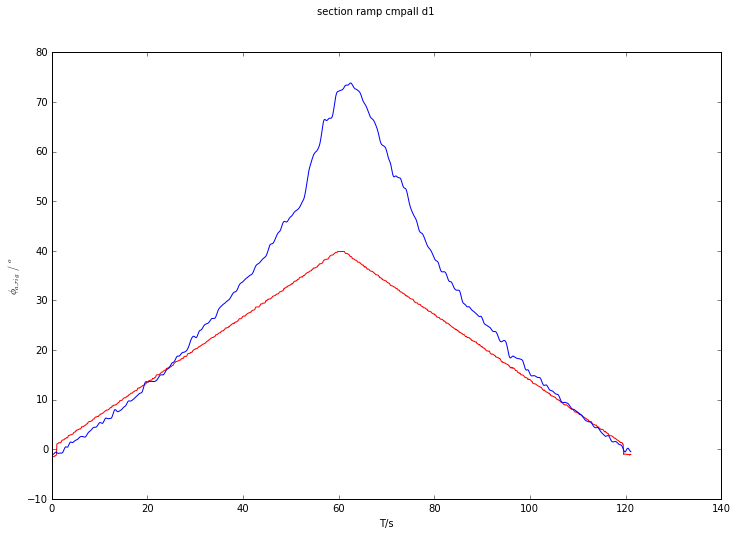

In [16]:
display_opt_params()

# show result
idx = range(len(sections))
display_data_for_test();

update_guess();

angeles = 
[-41, -35, -30, -25, -20, -15, -10, -5, 5, 10, 15, 20, 25, 30, 35, 41]
Clda_cmpx = 
[[ 0.05968291  0.0553231   0.04696643  0.03889542  0.03162213  0.0271057
   0.01839293  0.00900769 -0.00497219 -0.01407865 -0.02279645 -0.02607804
  -0.03158932 -0.03814162 -0.04606267 -0.05423365]
 [ 0.04821761  0.0404353   0.03394095  0.0276883   0.0223423   0.01843785
   0.01272706  0.00739553 -0.00449509 -0.00899431 -0.01628838 -0.01994654
  -0.02522128 -0.03103204 -0.03819486 -0.04861837]
 [ 0.04235569  0.03650224  0.02990824  0.02505072  0.01880923  0.01535756
   0.01121967  0.00679852 -0.0041091  -0.00866967 -0.01516793 -0.01995755
  -0.02558169 -0.03024035 -0.0346464  -0.03949022]
 [ 0.03393535  0.03038317  0.02596484  0.02259024  0.01868117  0.01450576
   0.00870284  0.00571733 -0.00445593 -0.00858266 -0.01293602 -0.0150844
  -0.01936097 -0.02433856 -0.03052023 -0.0351404 ]]


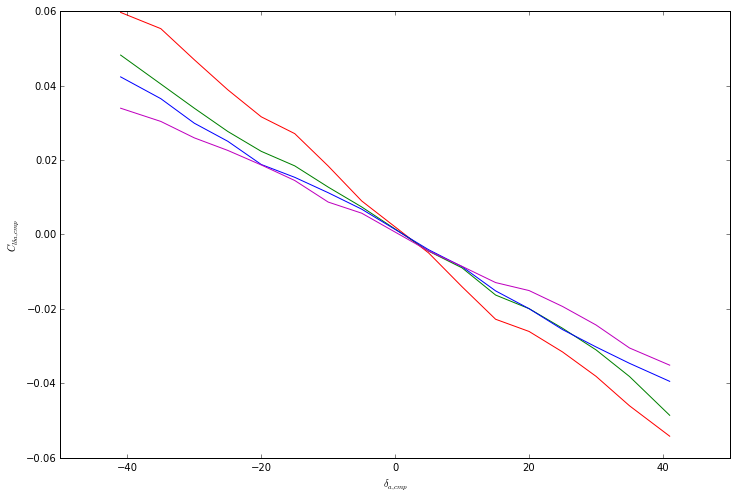

In [17]:
res_params = res['x']
params = param0[:]
for i,j in enumerate(opt_idx):
    params[j] = res_params[i]

k1 = np.array(params[0:angles_num])
k2 = np.array(params[angles_num:angles_num*2])
k3 = np.array(params[angles_num*2:angles_num*3])
k4 = np.array(params[angles_num*3:angles_num*4])

Clda_cmp1 = Clda_cmp*0.00436332313*k1*angles
Clda_cmp2 = Clda_cmp*0.00436332313*k2*angles
Clda_cmp3 = Clda_cmp*0.00436332313*k3*angles
Clda_cmp4 = Clda_cmp*0.00436332313*k4*angles

print('angeles = ')
print(angles)
print('Clda_cmpx = ')
print(np.vstack((Clda_cmp1,Clda_cmp2,Clda_cmp3,Clda_cmp4)))

%matplotlib inline
plt.figure(figsize=(12,8),dpi=300)
plt.plot(angles,  Clda_cmp1, 'r')
plt.plot(angles,  Clda_cmp2, 'g')
plt.plot(angles,  Clda_cmp3, 'b')
plt.plot(angles,  Clda_cmp4, 'm')
plt.xlabel('$\delta_{a,cmp}$')
plt.ylabel('$C_{l \delta a,cmp}$')
plt.show()

In [14]:
toggle_inputs()
button_qtconsole()

In [15]:
(-0.05-0.05)/(80/57.3)

-0.07162500000000001

In [16]:
Clda_cmp/4

-0.075975